In [4]:
%pip install dask[dataframe] -q
import pandas as pd
import numpy as np
from IPython.display import display

pd.set_option('display.max_columns', None)

Note: you may need to restart the kernel to use updated packages.


# STEP1. Processing cox-violent-parsed datasets

In [5]:
## This is the dataset that includes 'event' column which is equivalnet to 'is_violent_recid' column showing if a
# person violently recidivated
cvp_df = pd.read_csv('datasets/cox-violent-parsed_filt.csv')

## This transformed dataset contains a column for 'income' in place of 'sex' column in cvp_df (and race is changed
# to social-class in it with encoded text instead of race)
cvpt_df = pd.read_csv('datasets/cox-violent-parsed_filt_transformed.csv')

## Adding the income column to cvp_df
cvp_df['income'] = cvpt_df['income'].values

print(cvp_df.shape)
cvp_df.head(10)

(18316, 41)


,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,violent_recid,is_violent_recid,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event,income
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0,Lower
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0,Lower
2,3.0,michael ryan,michael,ryan,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,0,0,Lower
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,1.0,(F3),Felony Battery w/Prior Convict,1,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,1,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1,Lower
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
5,6.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
6,7.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
7,8.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
8,9.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
9,10.0,marcu brown,marcu,brown,Male,21/01/1993,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,1.0,(F3),Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,8,High,13/01/2013,Risk of Violence,6,Medium,1,0,Lower


In [6]:
## Out of about 18000 rows we only have 'id' for the first 11001
cvp_df = cvp_df.drop('id', axis=1)

## Sort so that rows with 'evnet' = 1 appear first
cvp_df_sorted = cvp_df.sort_values('event', ascending=False)

# Drop duplicate rows based on 'first' and 'last', keeping the first occurrence (which will have evnet = 1 if it exists)
cvp_df = cvp_df_sorted.drop_duplicates(subset=['first', 'last'], keep='first')

print(cvp_df.shape)
display(cvp_df.head())

(10855, 40)


,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,violent_recid,is_violent_recid,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event,income
1152,trevoy williams,trevoy,williams,Male,20/08/1995,20,Less than 25,Other,0,8,0,1,0,-1.0,29/10/2014 3:32,20/11/2014 8:32,1.0,(F3),Possession of Cocaine,1,(F3),0.0,20/03/2015,Possession Of Alprazolam,20/03/2015,NaN,1,(M2),20/03/2015,Assault,Risk of Recidivism,8,High,30/10/2014,Risk of Violence,6,Medium,0,1,Lower
1153,ian turnbull,ian,turnbull,Male,05/03/1989,27,25 - 45,African-American,0,8,0,0,13,-1.0,16/04/2013 7:03,17/04/2013 10:30,1.0,(M1),Possess Cannabis/20 Grams Or Less,1,(M1),NaN,06/04/2015,Battery,NaN,NaN,1,(M1),06/04/2015,Battery,Risk of Recidivism,8,High,17/04/2013,Risk of Violence,9,High,13,1,Lower
8083,bernard andrews,bernard,andrews,Male,05/04/1992,24,Less than 25,Other,0,8,0,0,3,-1.0,17/04/2014 9:15,20/04/2014 11:07,1.0,(M1),Battery,1,(M1),135.0,11/06/2014,Theft/To Deprive,24/10/2014,NaN,1,(M1),13/12/2014,Battery,Risk of Recidivism,8,High,18/04/2014,Risk of Violence,7,Medium,3,1,Lower
4329,lance geddes,lance,geddes,Male,20/04/1964,51,Greater than 45,African-American,0,2,0,0,0,0.0,08/05/2013 2:42,09/05/2013 9:51,0.0,(F3),Possession of Cocaine,1,(M1),NaN,15/11/2013,Battery,NaN,NaN,1,(M1),15/11/2013,Battery,Risk of Recidivism,2,Low,08/05/2013,Risk of Violence,1,Low,0,1,Lower
2447,benjamin robinson,benjamin,robinson,Male,04/07/1989,26,25 - 45,African-American,0,4,0,0,0,-1.0,01/02/2013 6:04,02/02/2013 5:16,1.0,(M1),Battery,1,(M1),0.0,06/02/2013,Resist/Obstruct W/O Violence,06/02/2013,NaN,1,(F2),20/05/2015,Agg Battery Grt/Bod/Harm,Risk of Recidivism,4,Low,02/02/2013,Risk of Violence,3,Low,0,1,Lower


In [7]:
## resetting and sorting indices
cvp_df = cvp_df.sort_index()
cvp_df = cvp_df.reset_index(drop=True)
display(cvp_df.head())

,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,violent_recid,is_violent_recid,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event,income
0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0,Lower
1,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,1.0,(F3),Felony Battery w/Prior Convict,1,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,1,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1,Lower
2,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,NaN,0,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0,Lower
3,marcu brown,marcu,brown,Male,21/01/1993,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,1.0,(F3),Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,8,High,13/01/2013,Risk of Violence,6,Medium,1,0,Lower
4,bouthy pierrelouis,bouthy,pierrelouis,Male,22/01/1973,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,76.0,(F7),arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,Risk of Recidivism,1,Low,26/03/2013,Risk of Violence,1,Low,2,0,Lower


In [8]:
cvp_df['event'].value_counts(normalize=True) * 100

event
0    92.464302
1     7.535698
Name: proportion, dtype: float64

### Dropping Unuseful Features

In [9]:
## Dropping unuseful and repetitive columns, but keeping first(name), last(name), and dob for joining the datasets later
cvp_df = cvp_df.drop(['name','age_cat','c_days_from_compas','violent_recid','type_of_assessment','v_type_of_assessment',
             'c_charge_desc', 'r_charge_desc', 'vr_charge_desc', 'decile_score.1', 'priors_count.1',], axis=1)

## Replacing jail in/out with jail duration
cvp_df['c_jail_in'] = pd.to_datetime(cvp_df['c_jail_in'], dayfirst=True)
cvp_df['c_jail_out'] = pd.to_datetime(cvp_df['c_jail_out'], dayfirst=True)
cvp_df['jail_duration'] = (cvp_df['c_jail_out'] - cvp_df['c_jail_in']).dt.days
cvp_df = cvp_df.drop(['c_jail_in', 'c_jail_out'], axis=1)

In [10]:
print(cvp_df.shape)
display(cvp_df.head())

(10855, 28)


,first,last,sex,dob,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_jail_in,is_violent_recid,vr_charge_degree,vr_offense_date,score_text,screening_date,v_decile_score,v_score_text,event,income,jail_duration
0,miguel,hernandez,Male,18/04/1947,69,Other,0,1,0,0,0,-1.0,(F3),0,NaN,NaN,NaN,NaN,0,NaN,NaN,Low,14/08/2013,1,Low,0,Lower,0.0
1,kevon,dixon,Male,22/01/1982,34,African-American,0,3,0,0,0,-1.0,(F3),1,(F3),NaN,05/07/2013,NaN,1,(F3),05/07/2013,Low,27/01/2013,1,Low,1,Lower,10.0
2,ed,philo,Male,14/05/1991,24,African-American,0,4,0,1,4,-1.0,(F3),1,(M1),0.0,16/06/2013,16/06/2013,0,NaN,NaN,Low,14/04/2013,3,Low,0,Lower,1.0
3,marcu,brown,Male,21/01/1993,23,African-American,0,8,1,0,1,NaN,(F3),0,NaN,NaN,NaN,NaN,0,NaN,NaN,High,13/01/2013,6,Medium,0,Lower,NaN
4,bouthy,pierrelouis,Male,22/01/1973,43,Other,0,1,0,0,2,NaN,(F7),0,NaN,NaN,NaN,NaN,0,NaN,NaN,Low,26/03/2013,1,Low,0,Lower,NaN


### Converting categorical scale variables to nummerical values

In [11]:
## Assigning numerical values to represent the intensity of different charge degrees.
charge_degree_mapping = {'(M1)': 1, '(M2)': 2, '(MO3)': 3, '(F1)': 6, '(F2)': 8, '(F3)': 10, '(F5)': 12, '(F6)': 14, '(F7)': 16}
cvp_df['c_charge_degree'] = cvp_df['c_charge_degree'].map(charge_degree_mapping)
cvp_df['r_charge_degree'] = cvp_df['r_charge_degree'].map(charge_degree_mapping)
cvp_df['vr_charge_degree'] = cvp_df['vr_charge_degree'].map(charge_degree_mapping)

### Converting to correct formats and some cleaning

In [12]:
## Converting date columns to datetime format
cvp_df['dob'] = pd.to_datetime(cvp_df['dob'], dayfirst=True)
cvp_df['r_offense_date'] = pd.to_datetime(cvp_df['r_offense_date'], dayfirst=True)
cvp_df['r_jail_in'] = pd.to_datetime(cvp_df['r_jail_in'], dayfirst=True)
cvp_df['vr_offense_date'] = pd.to_datetime(cvp_df['vr_offense_date'], dayfirst=True)
cvp_df['screening_date'] = pd.to_datetime(cvp_df['screening_date'], dayfirst=True)

## Replacing -1s with nan in event and is_recid
cvp_df['event'] = cvp_df['event'].replace(-1, np.nan)
cvp_df['is_recid'] = cvp_df['is_recid'].replace(-1, np.nan)

cvp_df['first'] = cvp_df['first'].str.lower()
cvp_df['last'] = cvp_df['last'].str.lower()

display(cvp_df.head())

,first,last,sex,dob,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_jail_in,is_violent_recid,vr_charge_degree,vr_offense_date,score_text,screening_date,v_decile_score,v_score_text,event,income,jail_duration
0,miguel,hernandez,Male,1947-04-18,69,Other,0,1,0,0,0,-1.0,10.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,Low,2013-08-14,1,Low,0,Lower,0.0
1,kevon,dixon,Male,1982-01-22,34,African-American,0,3,0,0,0,-1.0,10.0,1.0,10.0,NaN,2013-07-05,NaT,1,10.0,2013-07-05,Low,2013-01-27,1,Low,1,Lower,10.0
2,ed,philo,Male,1991-05-14,24,African-American,0,4,0,1,4,-1.0,10.0,1.0,1.0,0.0,2013-06-16,2013-06-16,0,NaN,NaT,Low,2013-04-14,3,Low,0,Lower,1.0
3,marcu,brown,Male,1993-01-21,23,African-American,0,8,1,0,1,NaN,10.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,High,2013-01-13,6,Medium,0,Lower,NaN
4,bouthy,pierrelouis,Male,1973-01-22,43,Other,0,1,0,0,2,NaN,16.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,Low,2013-03-26,1,Low,0,Lower,NaN


# STEP2. Processing compas-scores-raw dataset

In [13]:
## This database contains additional useful variables for predicting decile scores
csr_df = pd.read_csv('datasets/compas-scores-raw.csv')
print(csr_df.shape)
csr_df.head()

(60843, 28)


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [14]:
## Extracting different risk scores as independent columns
csr_df['RiskOfViolence_RawScore'] = csr_df.apply(lambda row: row.RawScore if row.Scale_ID == 7 else np.nan, axis=1)
csr_df['RiskOfViolence_DecileScore'] = csr_df.apply(lambda row: row.DecileScore if row.Scale_ID == 7 else np.nan, axis=1)
csr_df['RiskOfViolence_ScoreText'] = csr_df.apply(lambda row: row.ScoreText if row.Scale_ID == 7 else np.nan, axis=1)

csr_df['RiskOfRecidivism_RawScore'] = csr_df.apply(lambda row: row.RawScore if row.Scale_ID == 8 else np.nan, axis=1)
csr_df['RiskOfRecidivism_DecileScore'] = csr_df.apply(lambda row: row.DecileScore if row.Scale_ID == 8 else np.nan, axis=1)
csr_df['RiskOfRecidivism_ScoreText'] = csr_df.apply(lambda row: row.ScoreText if row.Scale_ID == 8 else np.nan, axis=1)

csr_df['RiskOfFailureToAppear_RawScore'] = csr_df.apply(lambda row: row.RawScore if row.Scale_ID == 18 else np.nan, axis=1)
csr_df['RiskOfFailureToAppear_DecileScore'] = csr_df.apply(lambda row: row.DecileScore if row.Scale_ID == 18 else np.nan, axis=1)
csr_df['RiskOfFailureToAppear_ScoreText'] = csr_df.apply(lambda row: row.ScoreText if row.Scale_ID == 18 else np.nan, axis=1)

In [15]:
csr_df.head(8)

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted,RiskOfViolence_RawScore,RiskOfViolence_DecileScore,RiskOfViolence_ScoreText,RiskOfRecidivism_RawScore,RiskOfRecidivism_DecileScore,RiskOfRecidivism_ScoreText,RiskOfFailureToAppear_RawScore,RiskOfFailureToAppear_DecileScore,RiskOfFailureToAppear_ScoreText
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0,-2.08,4.0,Low,NaN,NaN,NaN,NaN,NaN,NaN
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0,NaN,NaN,NaN,-1.06,2.0,Low,NaN,NaN,NaN
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1.0,Low
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0,-2.84,2.0,Low,NaN,NaN,NaN,NaN,NaN,NaN
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0,NaN,NaN,NaN,-1.50,1.0,Low,NaN,NaN,NaN
5,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,19.00,3,Low,New,1,0,NaN,NaN,NaN,NaN,NaN,NaN,19.0,3.0,Low
6,50855,57181,51963,PRETRIAL,DAYES,DANIEL,NaN,Male,African-American,08/25/94,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,4,High,7,Risk of Violence,-1.20,8,High,New,1,0,-1.20,8.0,High,NaN,NaN,NaN,NaN,NaN,NaN
7,50855,57181,51963,PRETRIAL,DAYES,DANIEL,NaN,Male,African-American,08/25/94,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,4,High,8,Risk of Recidivism,0.18,8,High,New,1,0,NaN,NaN,NaN,0.18,8.0,High,NaN,NaN,NaN


In [16]:
## Merging duplicate rows
repeated_columns = ['Person_ID','Agency_Text','LastName','FirstName','DateOfBirth','LegalStatus',
                    'CustodyStatus','MaritalStatus','RecSupervisionLevel','RecSupervisionLevelText']

risk_columns = ['RiskOfViolence_RawScore','RiskOfViolence_DecileScore','RiskOfViolence_ScoreText',
                'RiskOfRecidivism_RawScore','RiskOfRecidivism_DecileScore','RiskOfRecidivism_ScoreText',
                'RiskOfFailureToAppear_RawScore','RiskOfFailureToAppear_DecileScore','RiskOfFailureToAppear_ScoreText']

agg_dict = {col: 'first' for col in risk_columns}
csr_df = csr_df.groupby(repeated_columns).agg(agg_dict).reset_index()

In [17]:
csr_df['DateOfBirth'] = pd.to_datetime(csr_df['DateOfBirth'], format='%m/%d/%y')
csr_df['LastName'] = csr_df['LastName'].str.lower()
csr_df['FirstName'] = csr_df['FirstName'].str.lower()

csr_df = csr_df.drop('Person_ID', axis=1)
csr_df.shape

(19650, 18)

In [18]:
## dropping rows for the same person (in different stages) keeping the last record assuming it's more recent
csr_df = csr_df.drop_duplicates(subset=['FirstName', 'LastName'], keep='last')
csr_df.shape

(18050, 18)

# STEP3. Combining the two dataframes

In [19]:
## final data frame (fdf)
fdf = pd.merge(cvp_df, csr_df, left_on=['first', 'last', 'dob'], right_on=['FirstName', 'LastName', 'DateOfBirth'], how='inner')
fdf = fdf.drop(['first', 'last', 'dob'], axis=1)

In [20]:
print(fdf.shape)
display(fdf.head(20))

(8280, 43)


,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_jail_in,is_violent_recid,vr_charge_degree,vr_offense_date,score_text,screening_date,v_decile_score,v_score_text,event,income,jail_duration,Agency_Text,LastName,FirstName,DateOfBirth,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,RecSupervisionLevelText,RiskOfViolence_RawScore,RiskOfViolence_DecileScore,RiskOfViolence_ScoreText,RiskOfRecidivism_RawScore,RiskOfRecidivism_DecileScore,RiskOfRecidivism_ScoreText,RiskOfFailureToAppear_RawScore,RiskOfFailureToAppear_DecileScore,RiskOfFailureToAppear_ScoreText
0,Male,34,African-American,0,3,0,0,0,-1.0,10.0,1.0,10.0,NaN,2013-07-05,NaT,1,10.0,2013-07-05,Low,2013-01-27,1,Low,1,Lower,10.0,PRETRIAL,dixon,kevon,1982-01-22,Pretrial,Jail Inmate,Single,1,Low,-3.07,1.0,Low,-0.76,3.0,Low,25.0,6.0,Medium
1,Male,24,African-American,0,4,0,1,4,-1.0,10.0,1.0,1.0,0.0,2013-06-16,2013-06-16,0,NaN,NaT,Low,2013-04-14,3,Low,0,Lower,1.0,Probation,philo,ed,1991-05-14,Post Sentence,Probation,Single,3,Medium with Override Consideration,-1.27,7.0,Medium,0.49,9.0,High,28.0,8.0,High
2,Male,23,African-American,0,8,1,0,1,NaN,10.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,High,2013-01-13,6,Medium,0,Lower,NaN,PRETRIAL,brown,marcu,1993-01-21,Pretrial,Jail Inmate,Single,3,Medium with Override Consideration,-1.59,6.0,Medium,0.16,8.0,High,19.0,3.0,Low
3,Male,43,Other,0,1,0,0,2,NaN,16.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,Low,2013-03-26,1,Low,0,Lower,NaN,PRETRIAL,pierrelouis,bouthy,1973-01-22,Pretrial,Pretrial Defendant,Married,1,Low,-3.23,1.0,Low,-2.20,1.0,Low,12.0,1.0,Low
4,Male,44,Other,0,1,0,0,0,0.0,1.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,Low,2013-11-30,1,Low,0,Lower,1.0,PRETRIAL,miles,marsha,1971-08-22,Pretrial,Jail Inmate,Separated,1,Low,-3.30,1.0,Low,-1.93,1.0,Low,19.0,3.0,Low
5,Male,41,Caucasian,0,6,0,0,14,-1.0,10.0,1.0,8.0,0.0,2014-03-31,2014-03-31,0,NaN,NaT,Medium,2014-02-19,2,Low,0,Lower,6.0,PRETRIAL,riddle,edward,1974-07-23,Pretrial,Jail Inmate,Single,2,Medium,-2.89,2.0,Low,-0.16,6.0,Medium,30.0,8.0,High
6,Male,43,Other,0,4,0,0,3,-1.0,10.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,Low,2013-08-30,3,Low,0,Lower,0.0,PRETRIAL,stewart,steven,1973-02-25,Pretrial,Jail Inmate,Married,1,Low,-2.44,3.0,Low,-0.72,4.0,Low,20.0,3.0,Low
7,Male,20,Caucasian,0,10,0,1,0,-1.0,10.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,High,2013-12-09,9,High,0,Lower,33.0,PRETRIAL,blackburn,darrell,1995-11-16,Pretrial,Jail Inmate,Single,4,High,-0.83,9.0,High,0.82,10.0,High,17.0,2.0,Low
8,Female,26,Caucasian,0,5,0,0,0,-1.0,10.0,0.0,NaN,NaN,NaT,NaT,0,NaN,NaT,Medium,2014-09-05,3,Low,0,Higher,1.0,PRETRIAL,good,jamie,1989-04-23,Pretrial,Pretrial Defendant,Married,1,Low,-2.42,3.0,Low,-0.72,5.0,Medium,11.0,1.0,Low
9,Male,21,Caucasian,0,3,0,0,1,428.0,8.0,1.0,1.0,0.0,2015-01-06,2015-01-06,1,8.0,2015-01-06,Low,2013-11-04,5,Medium,1,Lower,0.0,Probation,bradac,bo,1994-06-10,Pretrial,Jail Inmate,Single,1,Low,-1.84,5.0,Medium,-0.79,3.0,Low,21.0,4.0,Low


# STEP4.Assessing the database for Accuracy

Note: you may need to restart the kernel to use updated packages.


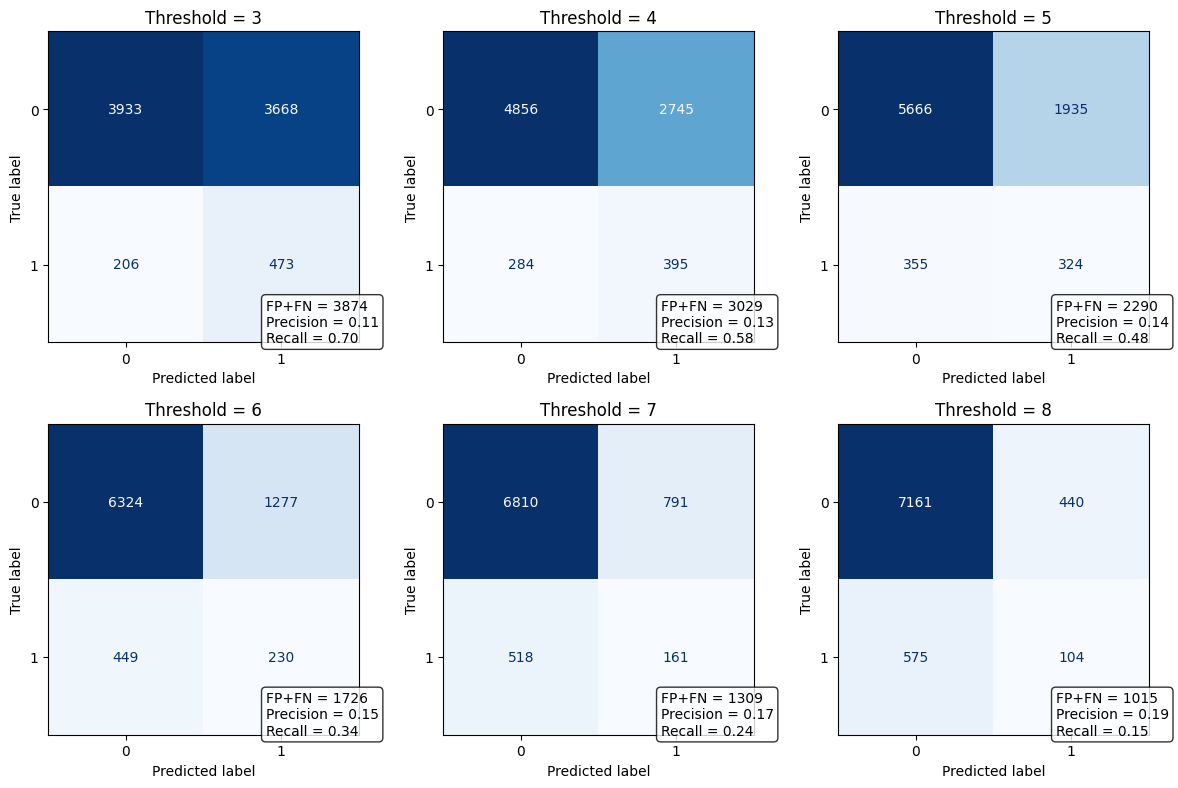

In [23]:
#following line not needed if on colab
%pip install matplotlib -q

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# thresholds = 1..10
thresholds = range(3, 9)

# We will need a 2 x 5 grid for ten thresholds
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

# Lists to store metrics for the second set of plots
precisions = []
recalls = []
fps_list = []
fns_list = []
fps_plus_fns_list = []

for idx, threshold in enumerate(thresholds):
    df = fdf.copy()
    df['binary_predictions'] = (df['v_decile_score'] > threshold).astype(int)

    # Get confusion matrix
    conf_matrix = confusion_matrix(df['event'], df['binary_predictions'])
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1])

    # Plot confusion matrix in each subplot
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues, values_format='d', colorbar=False)
    axes[idx].set_title(f"Threshold = {threshold}")

    # Extract TN, FP, FN, TP
    TN, FP, FN, TP = conf_matrix.ravel()

    # Calculate precision, recall, F1
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Store metrics for later plotting
    precisions.append(precision)
    recalls.append(recall)
    fps_list.append(FP)
    fns_list.append(FN)
    fps_plus_fns_list.append(FP + FN)

    # Write info onto each subplot
    text_str = (
        f"FP+FN = {FP + FN}\n"
        f"Precision = {precision:.2f}\n"
        f"Recall = {recall:.2f}"
    )
    axes[idx].text(
        0.7, 0.0, text_str,
        transform=axes[idx].transAxes,
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round')
    )

plt.tight_layout()
plt.show()

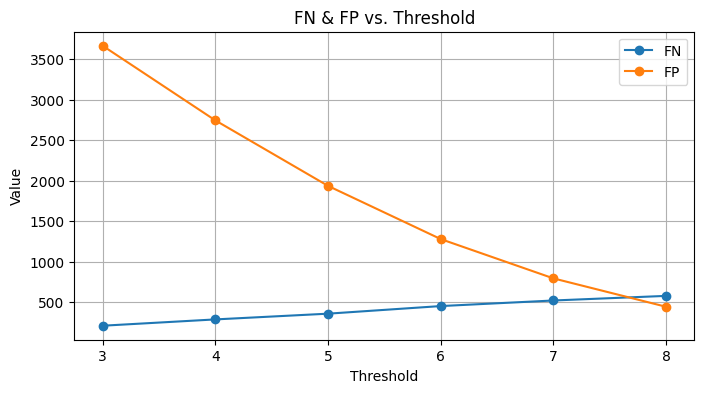

In [24]:
# Plot FN and FP vs. Threshold in a single figure
plt.figure(figsize=(8, 4))
plt.plot(thresholds, fns_list, marker='o', label='FN')
plt.plot(thresholds, fps_list, marker='o', label='FP')
plt.title('FN & FP vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.xticks(thresholds)
plt.legend()
plt.grid(True)
plt.show()

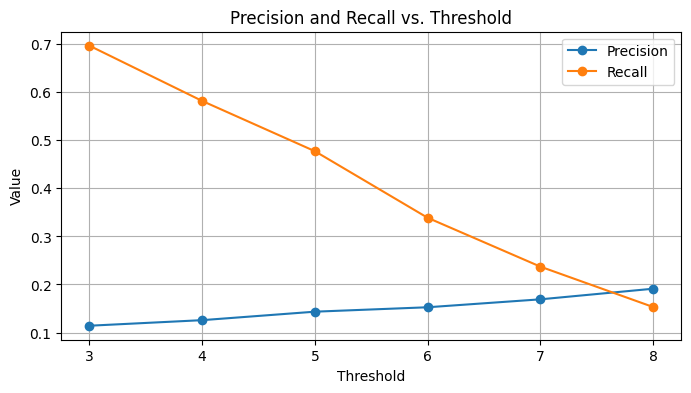

In [25]:
# Plotting precision and recall vs thresholds
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.plot(thresholds, recalls, marker='o', label='Recall')
plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.xticks(thresholds)
plt.legend()
plt.grid(True)
plt.show()

\# The very low precision of the predictions show that the algorithm is not working, and shouldn't be a basis for making decisions.

\# We will try to introduce a explainable model to improve the predictions. We will improve this model in collaboration with judges to refine feature selection and trainning.

In [26]:
#following line not needed if on colab
%pip install seaborn -q

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

threshold = 7
df = fdf.copy()
df['binary_predictions'] = (df['v_decile_score'] > threshold).astype(int)

# Generate and print the classification report
report = classification_report(df['event'], df['binary_predictions'])
print(f"Classification Report for threshold {threshold}:")
print(report)

# Generate the confusion matrix
cm = confusion_matrix(df['event'], df['binary_predictions'])
print("Confusion Matrix:")
print(cm)

Note: you may need to restart the kernel to use updated packages.
Classification Report for threshold 7:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      7601
           1       0.17      0.24      0.20       679

    accuracy                           0.84      8280
   macro avg       0.55      0.57      0.55      8280
weighted avg       0.87      0.84      0.85      8280

Confusion Matrix:
[[6810  791]
 [ 518  161]]


# STEP5: Imputing missing values

In [27]:
# Check missing values:
print(fdf.isnull().sum())

sex                                     0
age                                     0
race                                    0
juv_fel_count                           0
decile_score                            0
juv_misd_count                          0
juv_other_count                         0
priors_count                            0
days_b_screening_arrest               740
c_charge_degree                       470
is_recid                              448
r_charge_degree                      5463
r_days_from_arrest                   6402
r_offense_date                       5461
r_jail_in                            6402
is_violent_recid                        0
vr_charge_degree                     7601
vr_offense_date                      7601
score_text                              5
screening_date                          0
v_decile_score                          0
v_score_text                            1
event                                   0
income                            

### Imputing numerical columns

In [28]:
# To impute numerical columns we use Mean/Median Imputation
# Identify numeric columns (excluding categorical)
numeric_cols = fdf.select_dtypes(include=['number']).columns

# Initialize the imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')  # i used the median

# Apply imputation
fdf[numeric_cols] = imputer.fit_transform(fdf[numeric_cols])

In [29]:
# Check missing values after imputing the numerical columns:
print(fdf.isnull().sum())

sex                                     0
age                                     0
race                                    0
juv_fel_count                           0
decile_score                            0
juv_misd_count                          0
juv_other_count                         0
priors_count                            0
days_b_screening_arrest                 0
c_charge_degree                         0
is_recid                                0
r_charge_degree                         0
r_days_from_arrest                      0
r_offense_date                       5461
r_jail_in                            6402
is_violent_recid                        0
vr_charge_degree                        0
vr_offense_date                      7601
score_text                              5
screening_date                          0
v_decile_score                          0
v_score_text                            1
event                                   0
income                            

# Imputing categorical values

In [30]:
# Risk score we have (Low, Medium, High)
# Violent risk score (Low, Medium, High)
mode_cols = ["score_text","v_score_text", "RiskOfViolence_ScoreText","RiskOfRecidivism_ScoreText"]
for col in mode_cols:
    fdf[col].fillna(fdf[col].mode()[0], inplace=True)

# Date of prior offense, date of prior jail entry, and date of violent offense
    unknown_cols = [ "r_offense_date","r_jail_in","vr_offense_date"]

for col in unknown_cols:
    fdf[col].fillna("Unknown", inplace=True)

C:\Users\wissa\AppData\Local\Temp\ipykernel_21660\263880281.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fdf[col].fillna(fdf[col].mode()[0], inplace=True)
C:\Users\wissa\AppData\Local\Temp\ipykernel_21660\263880281.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [31]:
# check if there are any categorical missing values
print(fdf.isnull().sum())

sex                                  0
age                                  0
race                                 0
juv_fel_count                        0
decile_score                         0
juv_misd_count                       0
juv_other_count                      0
priors_count                         0
days_b_screening_arrest              0
c_charge_degree                      0
is_recid                             0
r_charge_degree                      0
r_days_from_arrest                   0
r_offense_date                       0
r_jail_in                            0
is_violent_recid                     0
vr_charge_degree                     0
vr_offense_date                      0
score_text                           0
screening_date                       0
v_decile_score                       0
v_score_text                         0
event                                0
income                               0
jail_duration                        0
Agency_Text              

### Download section

In [32]:
## Save the modified dataset
csv_filename = "datasets/final-preprocessed-imputed-compas-df.csv"
fdf.to_csv(csv_filename, index=False)
fdf.shape

(8280, 43)

In [33]:
## Downloading the file
try:
    from google.colab import files
    files.download(csv_filename)
except ImportError:
    print(f"Download manually from your working directory: {csv_filename}")

Download manually from your working directory: datasets/final-preprocessed-imputed-compas-df.csv
